Imports

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13


import os
import json
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import keras_tuner
from kerastuner.engine.trial import Trial
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import StandardScaler

#rng = np.random.default_rng(1758)


XGBoost version: 3.0.0


Read and split data

In [22]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")

N=5000, N_train=3750, L=4


show training and test sets

[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 0
[ 24.771  46.131 -49.161 -39.356] 0
[-20.13   15.641  30.981  37.218] 0
[46.465 22.369 14.248 21.745] 0


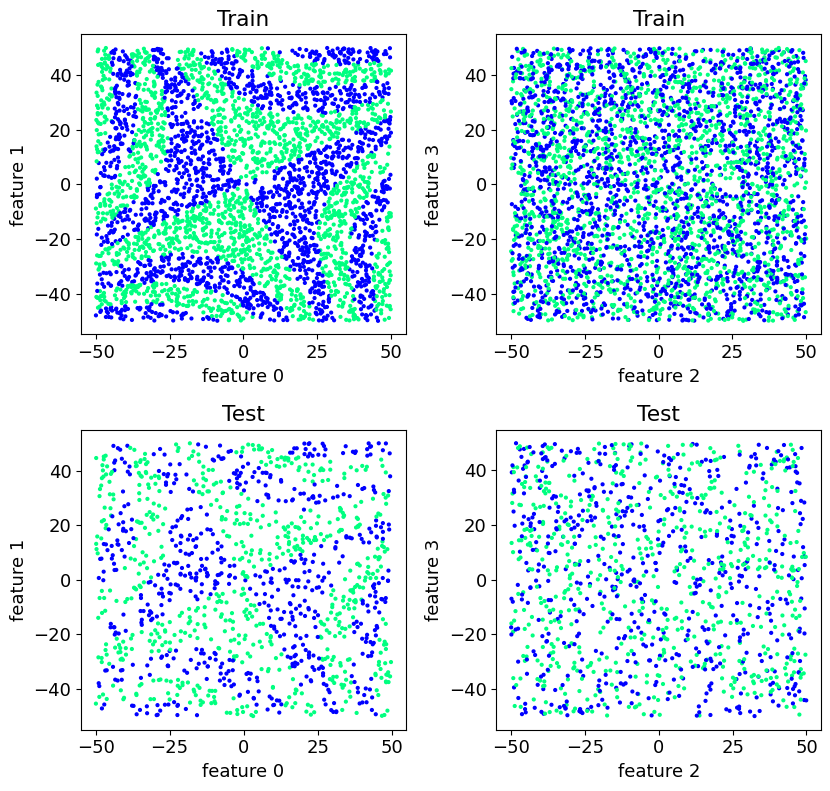

In [23]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [ ]:
def classify(clf=GradientBoostingClassifier(),show=True):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,L))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

### XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

## 1. Model complexity, parameters and regularization

We find the parameters $\lambda$, $\gamma$, and $n\_estimators$ that give us the best score by varying one parameter at a time and finding the best value. We iterated the procedure a few times to find the best combination of all three parameters.

In [25]:
lista_lr=[]

In [26]:

#change manually here
n_estimators=44
reg_lambda=1e-4

#Here we explore different values of the learning rate.
for learning_rate in range(1,17):
    model = XGBClassifier(seed=1,
                        objective='binary:logistic',
                        importance_type="gain", #weight, cover, ...
                        learning_rate=learning_rate/10,
                        reg_lambda=reg_lambda, 
                        n_estimators=n_estimators)
    
    model.fit(x_train,y_train)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-model.score(x_test, y_test)),model.score(x_test, y_test)))
    a=model.score(x_test,y_test)
    lista_lr.append((learning_rate/10,a)) 


errors: 11.28%   Accuracy=0.887
errors: 8.56%   Accuracy=0.914
errors: 7.68%   Accuracy=0.923
errors: 6.88%   Accuracy=0.931
errors: 8.48%   Accuracy=0.915
errors: 7.52%   Accuracy=0.925
errors: 7.84%   Accuracy=0.922
errors: 8.80%   Accuracy=0.912
errors: 9.12%   Accuracy=0.909
errors: 9.20%   Accuracy=0.908
errors: 8.64%   Accuracy=0.914
errors: 10.00%   Accuracy=0.900
errors: 9.92%   Accuracy=0.901
errors: 11.52%   Accuracy=0.885
errors: 11.84%   Accuracy=0.882
errors: 30.00%   Accuracy=0.700


Text(0, 0.5, 'Accuracy')

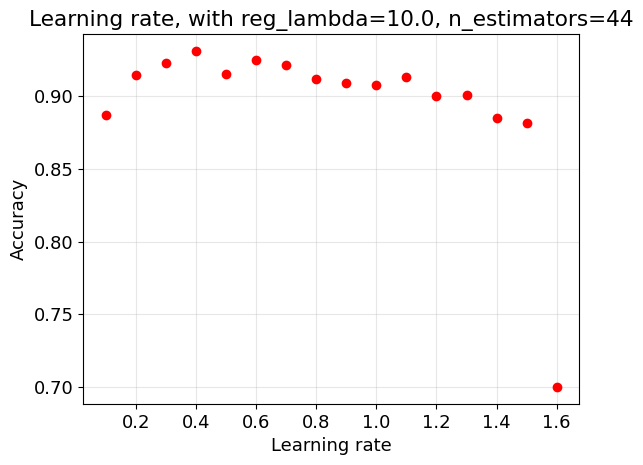

In [54]:
lr=np.array(lista_lr)
plt.scatter(lr[:,0],lr[:,1], zorder=2,c='r')
plt.grid(alpha=0.3,zorder=1)
stringa='Learning rate, with reg_lambda='+str(reg_lambda)+', n_estimators='+str(n_estimators)
plt.title(stringa)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
#plt.savefig('lr_1e-4_44')

We find that the model behaves well for a wide range of the learning rate.

In [ ]:
#with open('data_lr.txt',mode='a') as f:
#    print(reg_lambda,n_estimators,file=f)
#    print(lr,file=f)

In [50]:
lista_rl=[]

In [51]:
#change manually here
learning_rate=0.4
n_estimators=44

reg_lambdas=np.logspace(-9,1,num=11)
for reg_lambda in reg_lambdas:
    model = XGBClassifier(seed=1,
                        objective='binary:logistic',
                        importance_type="gain",
                        learning_rate=learning_rate,
                        reg_lambda=reg_lambda, 
                        n_estimators=n_estimators)

    model.fit(x_train,y_train)
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-model.score(x_test, y_test)),model.score(x_test, y_test)))
    a=model.score(x_test,y_test)
    lista_rl.append((reg_lambda,a)) 

errors: 7.52%   Accuracy=0.925
errors: 7.52%   Accuracy=0.925
errors: 7.52%   Accuracy=0.925
errors: 7.52%   Accuracy=0.925
errors: 7.68%   Accuracy=0.923
errors: 6.88%   Accuracy=0.931
errors: 7.28%   Accuracy=0.927
errors: 7.92%   Accuracy=0.921
errors: 8.08%   Accuracy=0.919
errors: 8.24%   Accuracy=0.918
errors: 8.80%   Accuracy=0.912


<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_3807/360091607.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('Regularization $\lambda$')


[(np.float64(1e-09), 0.9248), (np.float64(1e-08), 0.9248), (np.float64(1e-07), 0.9248), (np.float64(1e-06), 0.9248), (np.float64(1e-05), 0.9232), (np.float64(0.0001), 0.9312), (np.float64(0.001), 0.9272), (np.float64(0.01), 0.9208), (np.float64(0.1), 0.9192), (np.float64(1.0), 0.9176), (np.float64(10.0), 0.912)]


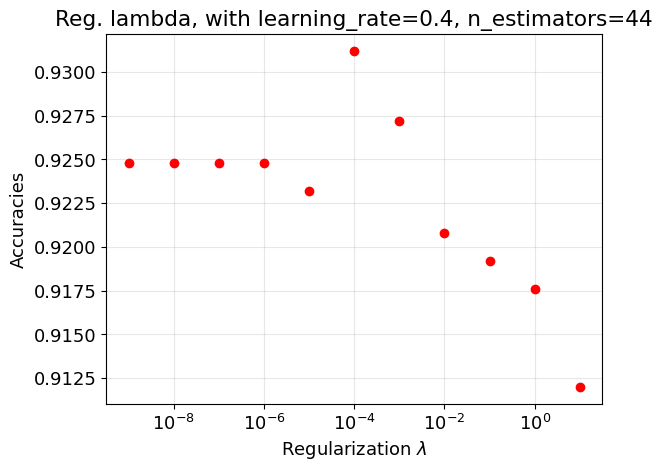

In [53]:
print(lista_rl)
rl=np.array(lista_rl)
plt.xscale('log')
plt.scatter(rl[:,0],rl[:,1],zorder=2,c='r')
plt.xlabel('Regularization $\lambda$')
plt.ylabel('Accuracies')
plt.grid(alpha=0.3, zorder=1)
stringa='Reg. lambda, with learning_rate='+str(learning_rate)+', n_estimators='+str(n_estimators)
plt.title(stringa)

plt.savefig('rl_4e-1_44_b')

The accuracies do not vary a lot with lambda and are kept very high in a wide range of values.

In [ ]:
#with open('data_rl.txt',mode='w') as f:
#    print(learning_rate,n_estimators,file=f)
#    print(rl,file=f)

In [55]:
lista_ne=[]

In [56]:
#change manually here
learning_rate=0.4
reg_lambda=1e-4


for n_estimators in range(2,51,2):
    model = XGBClassifier(seed=1,
                        objective='binary:logistic',
                        importance_type="gain",
                        learning_rate=learning_rate,
                        reg_lambda=reg_lambda, 
                        n_estimators=n_estimators)

    model.fit(x_train,y_train)
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-model.score(x_test, y_test)),model.score(x_test, y_test)))
    a=model.score(x_test,y_test)
    lista_ne.append((n_estimators,a)) 

errors: 20.08%   Accuracy=0.799
errors: 15.76%   Accuracy=0.842
errors: 15.04%   Accuracy=0.850
errors: 13.12%   Accuracy=0.869
errors: 11.52%   Accuracy=0.885
errors: 11.04%   Accuracy=0.890
errors: 9.76%   Accuracy=0.902
errors: 9.92%   Accuracy=0.901
errors: 9.44%   Accuracy=0.906
errors: 9.12%   Accuracy=0.909
errors: 8.56%   Accuracy=0.914
errors: 8.48%   Accuracy=0.915
errors: 8.40%   Accuracy=0.916
errors: 8.00%   Accuracy=0.920
errors: 7.68%   Accuracy=0.923
errors: 7.36%   Accuracy=0.926
errors: 7.92%   Accuracy=0.921
errors: 7.60%   Accuracy=0.924
errors: 7.76%   Accuracy=0.922
errors: 7.28%   Accuracy=0.927
errors: 6.96%   Accuracy=0.930
errors: 6.88%   Accuracy=0.931
errors: 7.28%   Accuracy=0.927
errors: 7.20%   Accuracy=0.928
errors: 7.20%   Accuracy=0.928


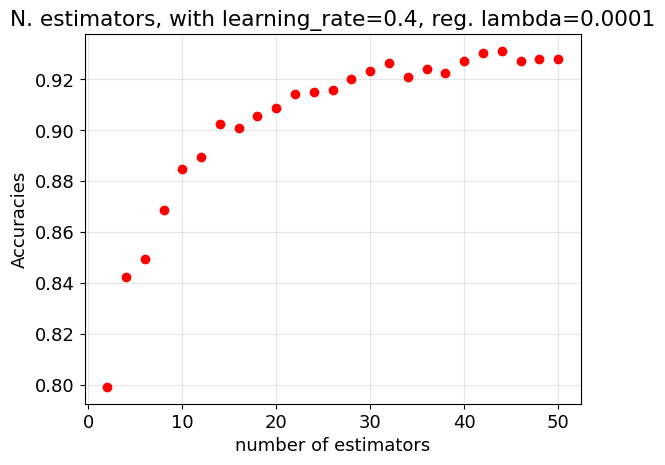

In [57]:
ne=np.array(lista_ne)
plt.scatter(ne[:,0],ne[:,1],zorder=2, c='r')
plt.grid(zorder=1,alpha=0.3)
stringa='N. estimators, with learning_rate='+str(learning_rate)+', reg. lambda='+str(reg_lambda)
plt.title(stringa)
plt.ylabel('Accuracies')
plt.xlabel('number of estimators')

plt.savefig('ne_4e-1_1e-4')

We see that the accuracies rise significantly in the first 20 values, but are already quite good even for the first numbers of estimators. 

In [ ]:
#with open('data_ne.txt',mode='w') as f:
#    print(learning_rate,reg_lambda,file=f)
#    print(ne,file=f)

### Comparing accuracies with and without regularization

We study how the accuracy varies with the number of estimators if we use and if we don't use regularization. We find that regularization is not necessary for a low number of estimators, while it improves the performance at a high number of estimators.

In [ ]:
scores_reg=[]
scores=[]
x=range(2,51,2)
for n_estimators in x:
    model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=0.4,
                    reg_lambda=1e-4, 
                    n_estimators=n_estimators)
    model.fit(x_train,y_train)
    sc_reg=model.score(x_test, y_test)
    scores_reg.append(sc_reg)

    model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=0.4,
                    reg_lambda=None, 
                    n_estimators=n_estimators)
    model.fit(x_train,y_train)
    sc=model.score(x_test, y_test)
    scores.append(sc)

Text(0, 0.5, 'Accuracies')

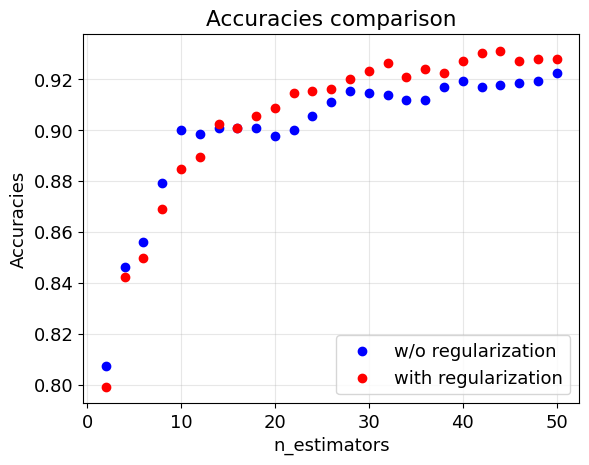

In [ ]:
plt.title('Accuracies comparison')
plt.grid(True,alpha=0.3, zorder=2.03)

plt.scatter(x,scores,c='b',label='w/o regularization', zorder=2.01)
plt.scatter(x,scores_reg,c='r',label='with regularization', zorder=2.02)
plt.legend(loc='lower right')
plt.xlabel('number of estimators')
plt.ylabel('Accuracies')

### Simplest model

We build a simple as possible model, with 2 estimators and without regularization.
We find that the model is still able to keep a high accuracy.

errors: 19.28%   Accuracy=0.807


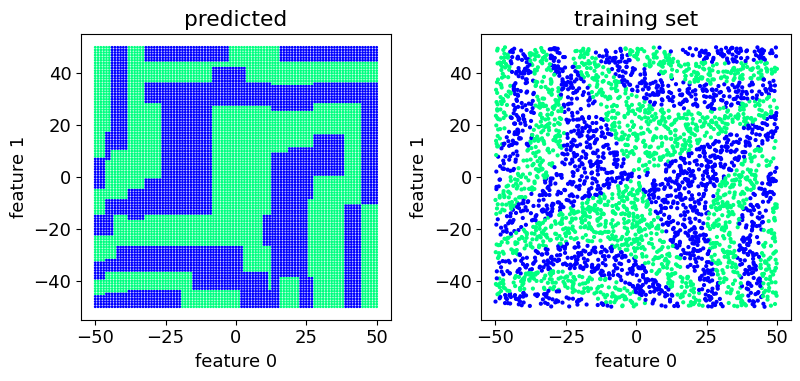

In [41]:
learning_rate=0.4
n_estimators=2
reg_lambda=None

simple_model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=learning_rate,
                    reg_lambda=reg_lambda, 
                    n_estimators=n_estimators)

simple_model.fit(x_train,y_train)
y_hat = simple_model.predict(x_test)
    
#print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-simple_model.score(x_test, y_test)),simple_model.score(x_test, y_test)))
classify(clf=simple_model,show=False)

## Best model
We show the best model given by the analysis of the parameters done above.

errors: 6.88%   Accuracy=0.931


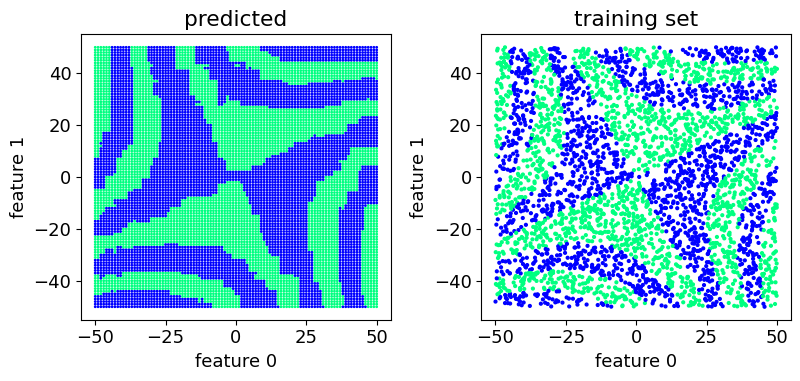

In [39]:
learning_rate=0.4
n_estimators=44
reg_lambda=1e-4

best_model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=learning_rate,
                    reg_lambda=reg_lambda, 
                    n_estimators=n_estimators)
classify(clf=best_model,show=False)


gain
[0.43326524 0.4256838  0.07108153 0.06996946]


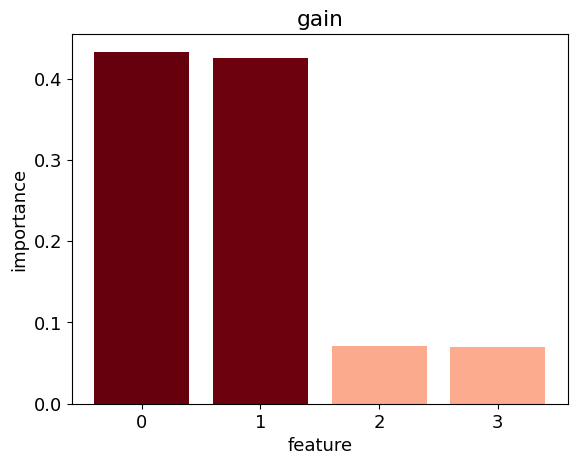

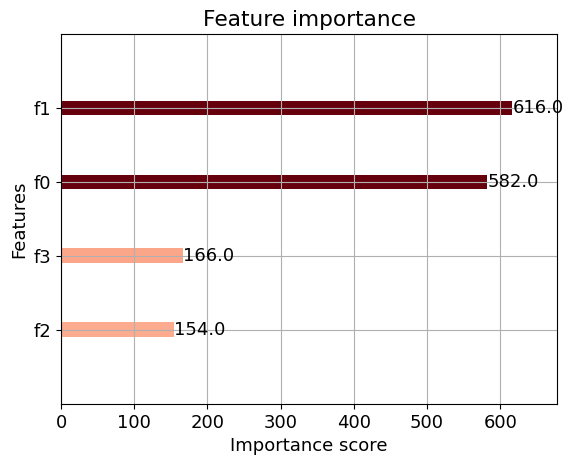

In [22]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance
print(best_model.importance_type)
print(best_model.feature_importances_)

# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_,
        color=my_cmap(rescale(best_model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(best_model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(best_model,color=my_cmap(rescale_r(best_model.feature_importances_)))
plt.show()

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [582. 616. 154. 166.]
1 gain [5.93998861 5.8360486  0.97451496 0.95926875]
2 total_gain [3457.07324219 3595.00585938  150.07530212  159.23861694]
3 cover [71.7477417  72.2924118  76.56706238 54.8244133 ]
4 total_cover [41757.1875     44532.125      11791.32714844  9100.85253906]


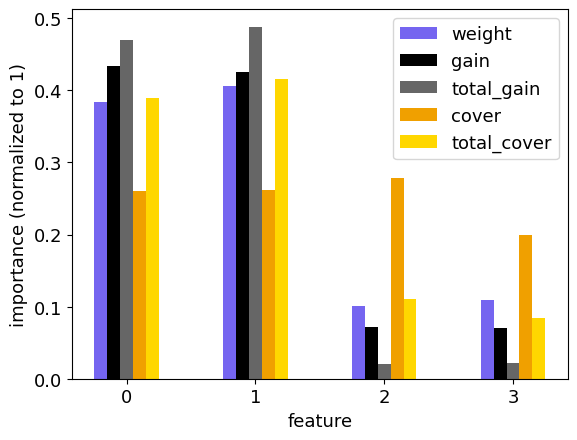

In [23]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = best_model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

## 2. dimensionality reduction

We remove feature 2 from the data and fit it using the simplest and the best model. We don't find any improvement for the simplest models, and we find also that the accuracy is slightly lower for the best model.

In [5]:
dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)

# REMOVING ONE FEATURE (feature 2)
x=np.delete(x,2,axis=1)

N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")


N=5000, N_train=3750, L=3


In [ ]:
learning_rate=0.4
n_estimators=44
reg_lambda=1e-4

reduced_best_model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=learning_rate,
                    reg_lambda=reg_lambda, 
                    n_estimators=n_estimators)
#classify(clf=reduced_best_model,show=False)

reduced_best_model.fit(x_train,y_train)
y_hat = reduced_best_model.predict(x_test)
    
print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-reduced_best_model.score(x_test, y_test)),reduced_best_model.score(x_test, y_test)))

errors: 7.28%   Accuracy=0.927


gain
[0.4542527  0.47359177 0.07215555]


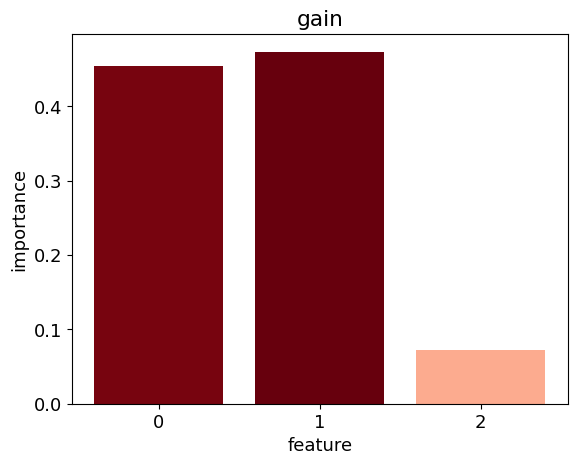

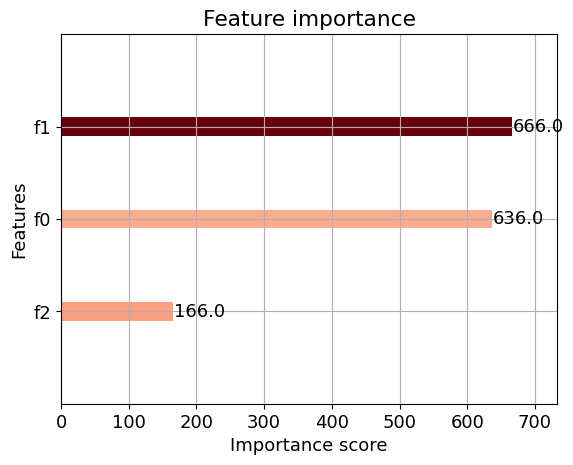

In [7]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance
print(reduced_best_model.importance_type)
print(reduced_best_model.feature_importances_)

# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(reduced_best_model.feature_importances_)), reduced_best_model.feature_importances_,
        color=my_cmap(rescale(reduced_best_model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(reduced_best_model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(reduced_best_model,color=my_cmap(rescale_r(reduced_best_model.feature_importances_)))
plt.show()

0 weight [636. 666. 166.]
1 gain [5.41434526 5.64485216 0.86003906]
2 total_gain [3443.5234375  3759.47143555  142.76647949]
3 cover [69.13506317 70.91998291 63.70800018]
4 total_cover [43969.90234375 47232.7109375  10575.52832031]


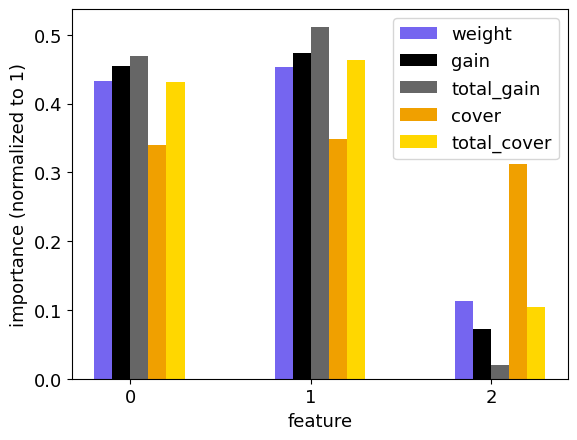

In [8]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = reduced_best_model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

In [ ]:
learning_rate=0.4
n_estimators=2
reg_lambda=None

reduced_simple_model = XGBClassifier(seed=1,
                    objective='binary:logistic',
                    importance_type="gain",
                    learning_rate=learning_rate,
                    reg_lambda=reg_lambda, 
                    n_estimators=n_estimators)

reduced_simple_model.fit(x_train,y_train)
y_hat = reduced_simple_model.predict(x_test)
    
print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-reduced_simple_model.score(x_test, y_test)),reduced_simple_model.score(x_test, y_test)))

errors: 19.28%   Accuracy=0.807


cover
[0.61371607 0.3862839  0.        ]


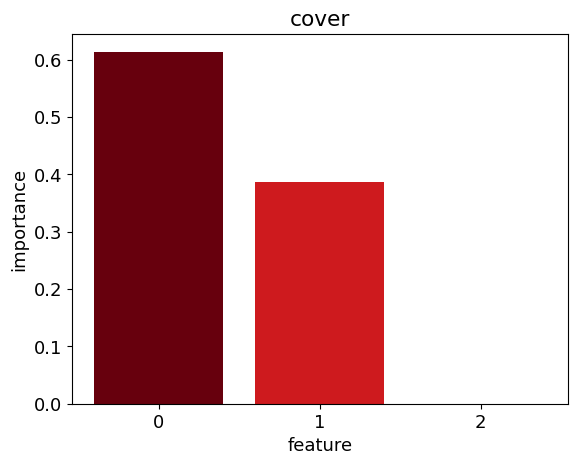

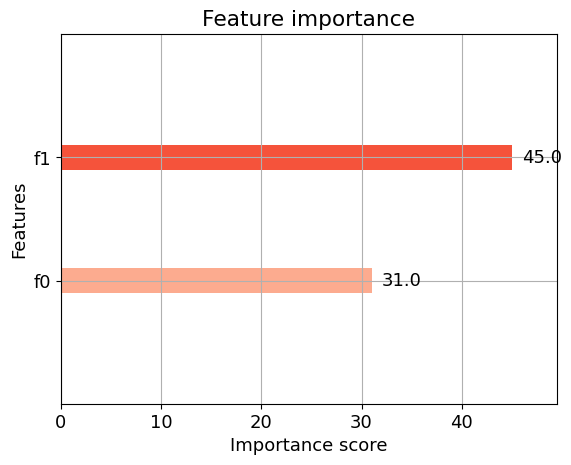

In [17]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance
print(reduced_simple_model.importance_type)
print(reduced_simple_model.feature_importances_)

# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(reduced_simple_model.feature_importances_)), reduced_simple_model.feature_importances_,
        color=my_cmap(rescale(reduced_simple_model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(reduced_simple_model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(reduced_simple_model,color=my_cmap(rescale_r(reduced_simple_model.feature_importances_)))
plt.show()

0 weight [31. 45.]
1 gain [27.42431068 29.13285637]
2 total_gain [ 850.15362549 1310.97851562]
3 cover [183.27957153 115.35945129]
4 total_cover [5681.66650391 5191.17529297]


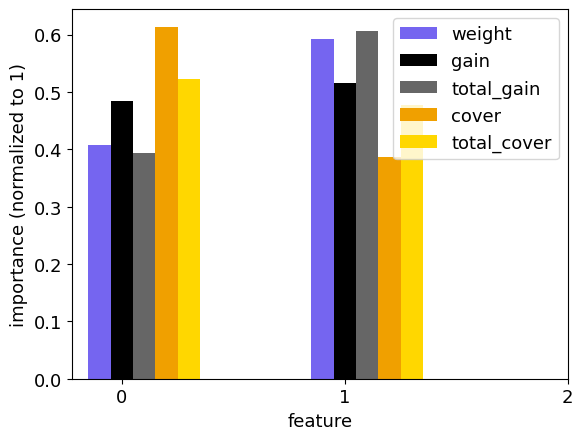

In [18]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = reduced_simple_model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L-1)+(i-(L-1)/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

## 3. XGBoost vs NN

In [ ]:
def build_model(hp):
    model = Sequential()
    
    # Input layer
    model.add(Dense(L, input_shape=(L,), activation='relu'))
    hidd_active = hp.Choice('hidd_activation', ['sigmoid','relu','elu'])
    
    # 3 hidden layers
    for layer_num in range(1, 4):
        model.add(Dense(20, activation=hidd_active))
        model.add(Dropout(hp.Float(f'Dropout_{layer_num}', min_value=0, max_value=0.2, step=0.1)))

    # Output layer
    model.add(Dense(1,activation='sigmoid'))
    learning_rate = hp.Choice('lr', [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
    hyper_optimizer = hp.Choice('optimizer', ['adam', 'sgd_nesterov', 'RMSprop', 'adamax', 'adagrad'])

    # Define sgd_nesterov
    if hyper_optimizer == 'sgd_nesterov': hyper_optimizer = SGD(learning_rate=learning_rate, nesterov=True)
        
    model.compile(loss='binary_crossentropy', optimizer=hyper_optimizer, metrics=["accuracy"])
    return model

In [ ]:


build_model(keras_tuner.HyperParameters()) # Construction of the model

# tuner definition
tuner = RandomSearch(hypermodel=build_model, 
                     objective="val_accuracy", # Tuner objective to maximize/minimize. We choose to maximize the validation
                     ## accuracy so as to pick a lower epoch number in case of overfitting.
                     max_trials=15,  # Number of models to be built.
                     executions_per_trial=1, # originally it was set at 3 trials in case of some errors happening due to
                     ## limited RAM or whatsoever.
                     overwrite=True, # avoids considering old models of previous runs.
                     project_name='search'# directory where trials are saved.
                     )
tuner.search(x_train[200:], y_train[200:], epochs=400, validation_data=(x_train[:200], y_train[:200]))

In [ ]:
fit = best_model.fit(x_train, y_train, batch_size = 50, validation_data=(x_test,y_test), verbose=0) # Training best model and evaluating it using the test dataset

In [ ]:
def Standardize(x,m,s):
    """
    Rescales each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss

In [ ]:

x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)
dX = .1
X1 = np.arange(0,10+dX, dX)
LG = len(X1)
X, Y = np.meshgrid(X1, X1)
allXY = np.reshape((np.array((X,Y)).T),(LG**2,2))
grid = np.random.rand(LG**2,L)*B
grid[:,:2] = allXY
grid_r=Standardize(grid,x_mean,x_std)

pred = best_model.predict(grid_r, verbose=0)

fig,AX=plt.subplots(1,3,figsize=(16,5.), layout='constrained')
fig.suptitle('Results', weight='bold',fontsize=20)
ax=AX[0]
ax.scatter(x[:,0],x[:,1],c=y,s=6)
ax.set_title("data")
ax=AX[1]
ax.pcolormesh(X1,X1,pred.reshape((LG, LG)))
ax.set_title("prediction $\\hat y$")
ax=AX[2]
pred01=np.copy(pred)
pred01[pred>0.5]=1
pred01[pred<=0.5]=0
ax.pcolormesh(X1,X1,pred01.reshape((LG, LG)))
ax.set_title("where $\\hat y > 1/2$")
plt.show()


## normal Gradient Boosting

errors: 19.76%   Accuracy=0.802


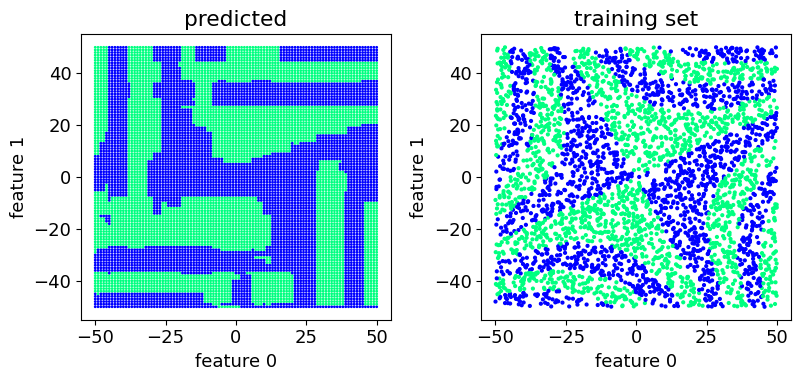

AttributeError: 'GradientBoostingClassifier' object has no attribute 'get_booster'

In [ ]:
#GradientBoostingClassifier()
classify()

## AdaBoost

errors: 40.72%   Accuracy=0.593


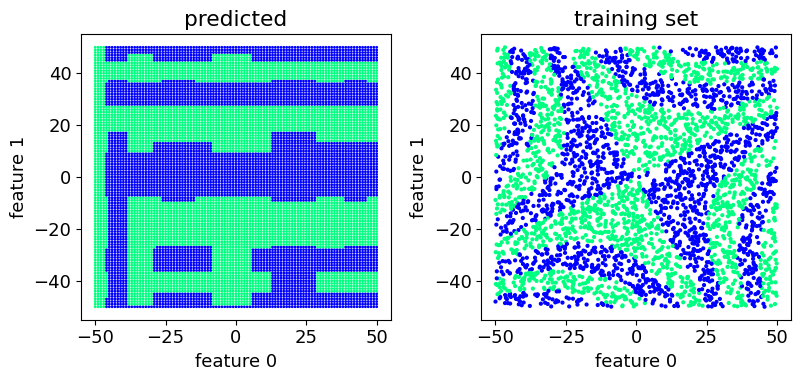

AttributeError: 'AdaBoostClassifier' object has no attribute 'get_booster'

In [116]:
classify(clf=AdaBoostClassifier(learning_rate=.8,n_estimators=150))